### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import scipy.stats as st
import scipy.interpolate as intr
from os import get_exec_path as gep
import utm

# define home folder
if gep()[0].find('amadella') >= 0:
    home = 'amadella'
else:
    home = 'andrea'

%matplotlib inline
sns.set(style='white')
sns.set_context("talk")

### Input filenames and parameters

In [62]:
# Specify working directory, unless this notebook is open in the working directory
# folder = '/Users/'+home+'/Documents/docs/src/Python/thermo_earthshape/'

# Input dem ASCII file name, with .txt extension
# the dem is best resampled to a reasonably low resolution before  importing it.
# If not, it won't be a problem, but it will increase computational time
dem_filename = 'grid_lc_clip.txt'

# Input Excel file name, with .xlsx extension
# This should be a table with the following header:
# lat, lon, elev, age, sd
ages_filename = 'LCTE_AHe.xlsx'

# Input target resolution of the interpolated surface [meters]
res = 500 

# Input utm zone
utm_zone = 19

# do you want to use Radial Basis Function?
# This interpolates also beyond the area covered by the samples
rbf_method = 'yes' # 'yes' or 'no'

# Do you want to extrapolate ages outside of the measured data points?
# if yes, which search radius so you want?
extra = 'no' # 'yes' or 'no'
rad = 2000 # meters

### Import input files and display them

DETAILS OF THE IMPORTED DEM

ncols = 241

nrows = 121

xllcorner = -71.200416424533

yllcorner = -33.000416206563

cellsize = 0.000833333333

Initial cellsize in meters = ~90



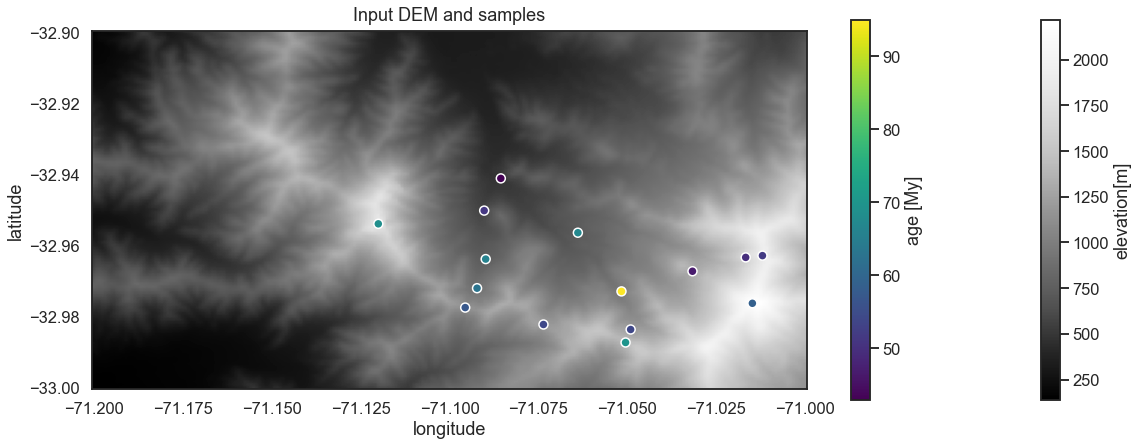

In [59]:
########################## Open DEM adnd read the metadata ##############################
##########################################################################################

fid = open(folder+dem_filename, 'r')

# def file_len(fname):
#     '''function to get number of lines in a txt file'''
#     with open(fname) as f:
#         for i,l in enumerate(f):
#             pass
#     return i+1

# make a table of the dem info and convert values to suitable data type
dem_info = [fid.readline().split() for i in range(6)]
dem_info = np.array(dem_info).transpose()
dem_info = dict([(k,v) for k,v in zip(dem_info[0],dem_info[1])])
dtypes = (int,int,float,float,float,int)
for i,f in zip(dem_info,dtypes):
    dem_info[i]=f(dem_info[i])

# get the dem data in list of strings
dem_ls_of_str = [fid.readline().split() for i in range(dem_info['nrows'])]
# and convert all cells to float
dem = np.array([[float(i) for i in dem_ls_of_str[j]] for j in range(dem_info['nrows'])])
if dem.shape != (dem_info['nrows'], dem_info['ncols']):
    print('something went wrong, nrow and/or ncols do nott match the original input')

# change NODATA_value to np.nan
dem[dem==dem_info['NODATA_value']]=np.nan

# Print details of imported DEM, except nodata value, who cares...?
print('DETAILS OF THE IMPORTED DEM')
print('')
for k,v in dem_info.items():
    if k != 'NODATA_value':
        print(k+' = '+str(v))
        print('')
print('Initial cellsize in meters = ~{}'.format(int(np.around(dem_info['cellsize']*110000,1)/10)*10))
print('')

################# Now open age dataset into a pd.DataFrame ##############################
##########################################################################################

data = pd.read_excel(folder+ages_filename)

z = data.elev.values
if z.mean()<10:
    z = z*1000 # from km to meters
a = data.age.values
w = data.sd.values
lat = data.lat.values
lon = data.lon.values

# convert geographic to projected coordinates
x_utm = np.array([])
y_utm = np.array([])
for i,v in enumerate(lat):
    xy_utm = utm.from_latlon(lat[i], lon[i]) #force_zone_number=utm_zone
    x_utm = np.append(x_utm, xy_utm[0])
    y_utm = np.append(y_utm, xy_utm[1])

# add points at -5000 m below sample elevation
# and add zero cooling age depth to arrays
# such that each x,y location has a double with age=0 and elev=z-5000
xx_utm = x_utm # double letters are the doubled vectors from now on (e.g. xx, yy, and so on)
yy_utm = y_utm
zz = z
aa = a
for i,v in enumerate(z):
    xx_utm = np.append(xx_utm, x_utm[i])
    yy_utm = np.append(yy_utm, y_utm[i])
    zz = np.append(zz, v-5000)
    aa = np.append(aa, 1e-9)

######################### Now plot dem and data points to check that everything worked fine ########
####################################################################################################

# specify the figure's geographical extent
extent84 = (dem_info['xllcorner'],
            dem_info['xllcorner']+dem_info['ncols']*dem_info['cellsize'],
            dem_info['yllcorner'],
            dem_info['yllcorner']+dem_info['nrows']*dem_info['cellsize'])

# make figure and axes
# you can edit the parameter "figsize" if the aspect ratio doesn't fit 
fig,ax = plt.subplots(1,1,figsize=(20,7))

# raster plot
im = ax.imshow(dem,
               origin='upper',
               cmap='Greys_r',
               extent=extent84
              )

# scatter plot
sct = ax.scatter(lon, lat, c=a,
                 cmap='viridis',
                 edgecolor='w'
                )

ax.set_aspect('equal')
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_title('Input DEM and samples',pad=10)
cb1 = fig.colorbar(im,)
cb2 = fig.colorbar(sct)
cb1.set_label('elevation[m]')
cb2.set_label('age [My]')

### Now Resample DEM to cellsize specified at the beginning and display it

Text(0, 0.5, 'northing')

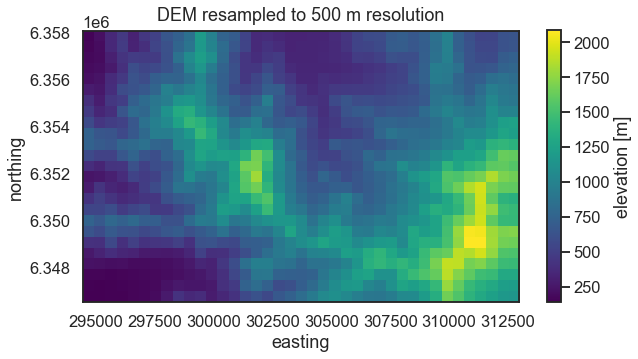

In [60]:
############################ First make all the coordinate grids #################################
##################################################################################################

# # make lon-lat vectors, (they are not needed to resample the dem)
# Xi84 = np.linspace(extent84[0], extent84[1], dem_info['ncols'])
# Yi84 = np.linspace(extent84[2], extent84[3], dem_info['nrows'])
# xi84, yi84 = np.meshgrid(Xi84,Yi84)

# convert llcorner and urcorner coordinates to utm and define extentUTM
xyll = utm.from_latlon(extent84[2], extent84[0]) #force_zone_number=utm_zone
xyur = utm.from_latlon(extent84[3], extent84[1]) #force_zone_number=utm_zone
extentUTM = (xyll[0], xyur[0], xyll[1], xyur[1])

# make high resolution easting and northing vectors, to be resampled
Xi = np.linspace(xyll[0], xyur[0], dem_info['ncols'])
Yi = np.linspace(xyll[1], xyur[1], dem_info['nrows'])
xi, yi = np.meshgrid(Xi,Yi)
yi = yi[::-1] ############################## flipped row order for latitude to decrease
# 1d vectors for interpolation
xi_1d = xi.reshape(xi.size)
yi_1d = yi.reshape(yi.size)
zi_1d = dem.reshape(dem.size)

# make lower resolution easting and northing vectors
Xi_res = np.arange(xyll[0], xyur[0]+res, res)
Yi_res = np.arange(xyll[1], xyur[1]+res, res)
xi_res, yi_res = np.meshgrid(Xi_res, Yi_res)
yi_res = yi_res[::-1] ############################# flipped row order for latitude to decrease
xi_res_1d = xi_res.reshape(xi_res.size)
yi_res_1d = yi_res.reshape(yi_res.size)

################## Then resample (nearest neighbour) at new grid nodes ############################
###################################################################################################

# resample by interpolating at larger steps (specified as "res")
# input_coords are organized in a 2D array, with columns representing x,y
input_coords = np.concatenate(([xi_1d],[yi_1d])).transpose()

# resampled coords are organized in a 2D array, with columns representing x,y
res_coords = np.concatenate(([xi_res_1d],[yi_res_1d])).transpose()

# Now run resample: the 'values' variable refers to the known elevations of the input dem
zi_res_1d = intr.griddata(points=input_coords, values=zi_1d, xi=res_coords, method='nearest')
zi_res = zi_res_1d.reshape(xi_res.shape) # reshape from 1D to 2D

#################################### Now plot it ##################################################
###################################################################################################

fig,ax = plt.subplots(1,1,figsize=(10,5))

im = ax.imshow(zi_res, origin='upper', extent=extentUTM, cmap='viridis')
ax.set_aspect('equal')
cb = fig.colorbar(im)
cb.set_label('elevation [m]')
ax.set_title('DEM resampled to {} m resolution'.format(res),pad=10)
ax.set_xlabel('easting')
ax.set_ylabel('northing')

### Interpolate age data onto the topographic surface

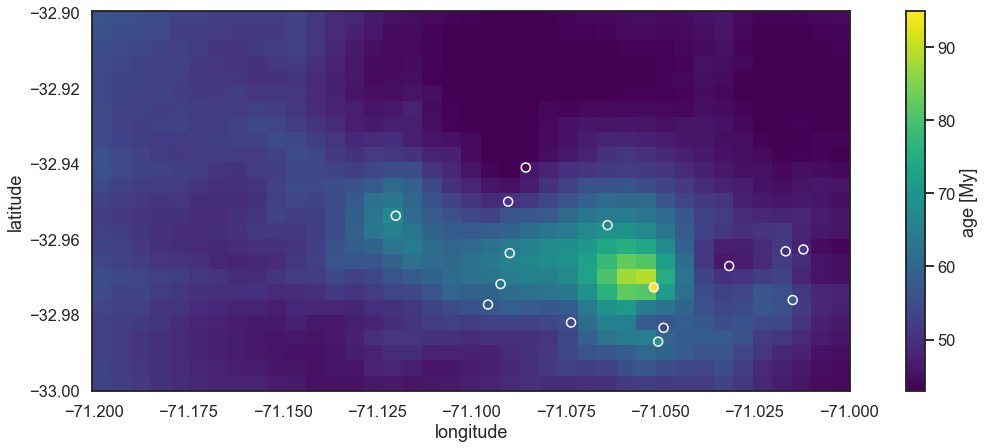

In [63]:
##################################### Run griddata linear interpolation ############################
####################################################################################################

# known data points, for which the interpolation function is found
# they are organized in a 2D array, with columns representing x,y,z
pts = np.concatenate(([xx_utm],[yy_utm],[zz])).transpose()

# positions where interpolation needs to be made (all the catchment's gridcells)
# they are organized in a 2D array, with columns representing x,y,z
pos = np.concatenate(([xi_res_1d],[yi_res_1d],[zi_res_1d])).transpose()
#pos_zfix = np.concatenate(([xi_sam_1d],[yi_sam_1d],[zi_sam_1d])).transpose()

# Now run the interpolation.

# use Radial Basis Function interpolation if specified
if rbf_method == 'yes':
    rbfi = intr.Rbf(xx_utm, yy_utm, zz, aa, function='linear')
    age_interp_map = rbfi(xi_res, yi_res, zi_res)
    age_interp = age_interp_map.reshape(age_interp_map.size)
    
# alternatively use griddata interpolation
elif rbf_method == 'no':
    # the 'values' variable refers to the known ages of the data points
    age_interp = intr.griddata(points=pts, values=aa, xi=pos)
    age_interp_map = age_interp.reshape(zi_res.shape)

######################### If desired, extrapolate points at the edges ############################
####################### Using a weighted normalized inverse distance function ####################
###################################################################################################

def extrapolation(gdop, gdopx, gdopy, gdopz, data, datax, datay, dataz, rad, gdop2D):
    '''
    Extrapolates data within wanted radius
    using an inverse distance weighted average of the available data points
    input arguments:
    gdop: griddata output,
          a 1D-array that contains the interpolated data
          as well as the nans that you want to replace
          
    '''

    # select only nans out of the griddata output 
    nans = gdop[gdop!=gdop]
    nansx = gdopx[gdop!=gdop]
    nansy = gdopy[gdop!=gdop]
    nansz = gdopz[gdop!=gdop]

    # define distance function
    def dist3D(xyz1, xyz2):
        '''
        Calculates the distance between two points in 3D.
        xyz1 - list or tuple of x,y,z coords for first point
        xyz2 - list or tuple of x,y,z coords for second point
        '''
        return np.sqrt((xyz1[0]-xyz2[0])**2+(xyz1[1]-xyz2[1])**2+(xyz1[2]-xyz2[2])**2)

    # This is the workflow of the extrapolation function:
    # for each of the nans
        # calculate inverse distance from NaN to all samples, drop samples too far away
        # multiply inverse distances by related age and store in a [1 x M] vector of weighted values
        # summate and divide by M

    for i in np.arange(nans.size):
        # make array of ages divided by distance and number of data points
        dists = np.array([dist3D((nansx[i],nansy[i],nansz[i]),(datax[j],datay[j],dataz[j])) for j in np.arange(data.size)])
        dists1 = dists[dists < rad] # do not consider points farther than rad
        data1 = data[dists < rad] # select related ages 
        dists1 = 1/dists1 # invert distances
        weighted_ages = np.array([dists1[k]*data1[k] for k in np.arange(data1.size)])
        nans[i] = weighted_ages.sum()/dists1.sum() # compute weighted average
        # should add a way to extrapolate to different elevations than the closest points

    # now substitute nans with extrapolated values
    gdop[gdop!=gdop] = nans
    return gdop.reshape(gdop2D.shape)

if extra == 'yes':
    #assign arguments
    gdop = age_interp.copy() # GridData OutPut
    gdopx = xi_res_1d # array of griddata output x coordinates
    gdopy = yi_res_1d # array of griddata output y coordinates
    gdopz = zi_res_1d # array of griddata output z coordinates

    data = a # data points values to interpolate
    datax = x_utm # data points x coord
    datay = y_utm # data points y coord
    dataz = z # data points z coord

    gdop2D = zi_res # 2D grid related to gdop, needed to reshape final output to correct gridsize
    
    # call the function
    extra_grid = extrapolation(gdop, gdopx, gdopy, gdopz, data, datax, datay, dataz, rad, gdop2D)

#################################### And plot it ##################################################
###################################################################################################

    
fig,ax = plt.subplots(1,1,figsize=(20,7))

if extra == 'yes':
    # plot bedrock surface age map including extrapolation
    im = ax.imshow(extra_grid,
                   origin='upper',
                   extent=extentUTM,
                   cmap='viridis',
                   vmin=a.min(),
                   vmax=a.max(),
                   alpha=1 # trasparency param
                  )
else:
    # plot bedrock surface age map
    im = ax.imshow(age_interp_map,
                   origin='upper',
                   extent=extent84,
                   cmap='viridis',
                   vmin=a.min(),
                   vmax=a.max(),
                   alpha=1 # trasparency param
                  )

# plot samples and ages
ax.scatter(x=lon,
           y=lat,
           c=a,
           cmap='viridis',
           vmin=a.min(),
           vmax=a.max(),
           edgecolor='w'
          )

ax.set_aspect('equal')
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
cb = fig.colorbar(im)
cb.set_label('age [My]')

### Bootstrap to produce error map

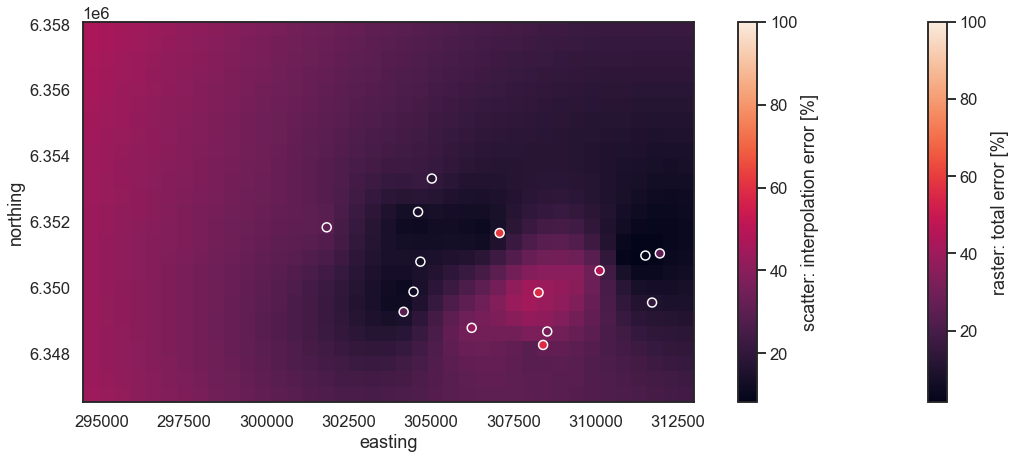

In [44]:
# pre-allocate a vector with as many elements as bedrock samples
error_interp = np.zeros(lat.size) # np.zeros(lat.size)

# Bootstrap:
# for each bedrock sample
# 1. exclude the related point from input data
# 2. calculate an interpolated surface age at its location
# 3. save the difference to the known measured age.
for i in np.arange(lat.size):
    a_boot = np.delete(aa, i)
    x_boot = np.delete(xx_utm, i)
    y_boot = np.delete(yy_utm, i)
    z_boot = np.delete(zz, i)
    
    # use Radial Basis Function interpolation if specified
    if rbf_method == 'yes':
        rbfi = intr.Rbf(x_boot, y_boot, z_boot, a_boot, function='linear')
        a_int = rbfi(xx_utm[i], yy_utm[i], zz[i]) # get interpolated age of excluded sample
        
    else:
        pts1 = np.concatenate(([x_boot],[y_boot],[z_boot])).transpose() # data without i sample
        pos1 = np.concatenate(([xx_utm[i]], [yy_utm[i]], [zz[i]])) # coordinates of i sample
        a_int = intr.griddata(points=pts1, values=a_boot, xi=pos1)[0]
    
    error_interp[i] = abs(aa[i]-a_int)/aa[i]*100
    
# calculate sqrt of the square interp error + square measurement error (?)
error_total = np.sqrt(error_interp**2+(w/a*100)**2)
# substitute nans at edge of interpolation with mean error
error_total[error_total!=error_total] = np.nanmean(error_total)

##################################### Make the map ################################
###################################################################################
# with RBF if specified
if rbf_method == 'yes':
    rbfi = intr.Rbf(x_utm, y_utm, z, error_interp, function='linear')
    age_interp_error_map = rbfi(xi_res, yi_res, zi_res) # get interpolated age of excluded sample
    

# otherwise with Griddata interpolation
else:
    pts_err = np.concatenate(([x_utm],[y_utm])).transpose()
    age_interp_error = intr.griddata(points=pts_err, values=error_total, xi=res_coords)

    # preallocate array
    age_interp_error_map = np.ones(zi_res.shape)

    for i in np.arange(age_interp_error.size):
        x_ind = int(np.rint((xi_res_1d[i]-xyll[0])/res))
        y_ind = int(np.rint((yi_res_1d[i]-xyll[1])/res))

        # assign nan if out of the catchment bounds
        if zi_res[y_ind][x_ind] != zi_res[y_ind][x_ind]:
            age_interp_error_map[y_ind][x_ind] = np.nan

        else:
            age_interp_error_map[y_ind][x_ind] = age_interp_error[i]

    age_interp_error_map = age_interp_error_map[::-1] # flipped to have correct latitude

# extrapolation
if extra == 'yes':
    #assign arguments
    gdop = age_interp_error_map.reshape(age_interp_error_map.size) # GridData OutPut in 1D
    gdopx = xi_res_1d # array of griddata output x coordinates
    gdopy = yi_res_1d # array of griddata output y coordinates
    gdopz = zi_res_1d # array of griddata output z coordinates

    data = error_total # data points values to interpolate
    datax = x_utm # data points x coord
    datay = y_utm # data points y coord
    dataz = z # data points z coord

    gdop2D = zi_res # 2D grid related to gdop, needed to reshape final output to correct gridsize
    
    # call the function
    extra_errormap = extrapolation(gdop, gdopx, gdopy, gdopz, data, datax, datay, dataz, rad, gdop2D)

##################################### Plot the error map ################################
#########################################################################################

fig,ax = plt.subplots(1,1,figsize=(20,7))

if extra == 'yes':
    # plot error map including extrapolation
    im = ax.imshow(extra_errormap,
                   origin='upper',
                   extent=extentUTM,
                   vmax=100,
                   alpha=1 # trasparency param
                  )
else:
    # plot error map
    im = ax.imshow(age_interp_error_map,
                   origin='upper',
                   extent=extentUTM,
                   vmax=100
                  )

sct = ax.scatter(x=x_utm, y=y_utm, c=error_total, edgecolor='w',vmax=100)

ax.set_aspect('equal')
ax.set_xlabel('easting')
ax.set_ylabel('northing')
cb = fig.colorbar(im)
cb1 = fig.colorbar(sct)
cb.set_label('raster: total error [%]')
cb1.set_label('scatter: interpolation error [%]')

### Make erosion Grid?

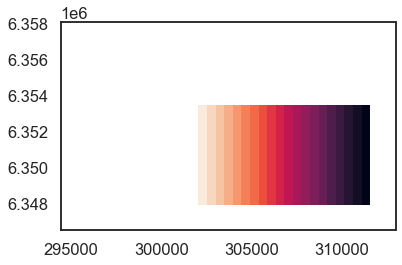

In [7]:
from make_erosion_map import make_erosion_map

# some of the points should be located out of the catchment,
# in order to obtain an interpolated surface that covers it all
pts = [[302000,6348000,100],
       [302000,6354000,100],
       [312000,6348000,1],
       [312000,6354000,1]]

# use linear interpolation function to make up an erosion map
Emap = make_erosion_map(xi_res,yi_res,pts)
# Emap = make_erosion_map(ws_coords['xi'],ws_coords['yi'],pts)
plt.imshow(Emap, extent=extentUTM)

# Save grids and output table with x, y, elev, age, error, erosion
- First crop X,Y, elev data to watershed

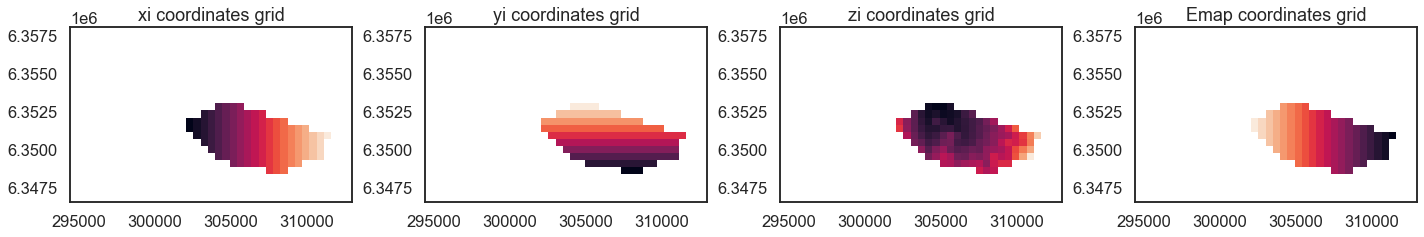

In [8]:
ws_coords = {} # allocate dictionary
grids = [xi_res, yi_res, zi_res, Emap, ] # grids to crop
labels = ['xi', 'yi', 'zi', 'Emap'] # labels for dictionary

for g,l in zip(grids, labels):
    np.savetxt(l+'.csv', g, delimiter=",")
    ws_coords[l] = g.copy()
    ws_coords[l][age_interp_map!=age_interp_map] = np.nan
    
# plot the grids to check if they make sense
fig,ax = plt.subplots(1,4, figsize=(20,10))
for ax,g,l in zip(ax.ravel(),ws_coords.values(),ws_coords.keys()):
    ax.imshow(g,extent=extentUTM)
    ax.set_title(l+' coordinates grid')
plt.tight_layout()

- Then make output table

In [9]:
# make OutPut table
op = pd.DataFrame()
for k in ws_coords.keys():
    op[k] = ws_coords[k][age_interp_map==age_interp_map] # drop the nans and reshape to 1D-array
op['A'] = age_interp_map[age_interp_map==age_interp_map]
op['A_u%'] = age_interp_error_map[age_interp_map==age_interp_map]

# save to excel ?
op.to_excel('interp_output.xlsx', index=False)

op.head()

,xi,yi,zi,Emap,A,A_u%
0,304426.515795,6.353016e+06,567.0,75.977494,45.210760,31.916111
1,304926.515795,6.353016e+06,513.0,71.027494,45.068688,27.022228
2,305426.515795,6.353016e+06,524.0,66.077494,46.781140,37.215534
3,305926.515795,6.353016e+06,617.0,61.127494,43.318538,32.252000
4,303426.515795,6.352516e+06,884.0,85.877494,51.968249,31.056559


## Develop function to clip to watershed

In [ ]:
# clip to watershed
import fiona
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from shapely.geometry import Polygon

# arr = znew[::-1] # need to invert because of origin in upper corner?
transform = rasterio.transform.from_origin(extentUTM[0], extentUTM[3], res, res) ######### FIX CELLSIZE PROBLEM!!!!!!
crs = rasterio.crs.CRS.from_epsg(32719) # wgs1984: 4326 

src = rasterio.open('LC_inter_0.tif',
                    'w',
                    driver='GTiff',
                    height = age_interp_error_map.shape[0],
                    width = age_interp_error_map.shape[1],
                    count = 1,
                    dtype = str(age_interp_error_map.dtype),
                    crs = crs,
                    transform=transform)

src.write(age_interp_error_map, 1)
src.close()
src = rasterio.open('LC_inter_0.tif', 'r')
# show(src, cmap='viridis')
# plt.imshow(src.read(1),extent=extentUTM, origin='upper')

path_shp = '/Users/'+home+'/Documents/data/data_large/ArcGIS/earthshape/watersheds/ws_lc.shp'

with fiona.open(path_shp,'r') as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]
    # convert to UTM the vertices of the imported polygon
    shapes[0]['coordinates'] = [[utm.from_latlon(coo[1],coo[0])[:2] for coo in shapes[0]['coordinates'][0]]]

with rasterio.open('LC_inter_0.tif','r') as src:
    out_image, out_transform = mask(src, shapes, crop=True, nodata=np.nan)
    out_meta = src.meta
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open("LC_masked.tif", "w", **out_meta) as dest:
    dest.write(out_image)
ws = rasterio.open('LC_masked.tif')

# show(ws, contour=False, cmap='viridis')
# plt.imshow(ws.read(1),extent=extentUTM, origin='upper')
age_interp_error_map = ws.read(1)
age_interp_error = age_interp_error_map.reshape(age_interp_error_map.size)